# 3.0 Cluster Analysis

**Tasks**: Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods**: Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.
Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

## Outline of this notebook:
1. Helper Functions
2. Adding Additional Features
3. Feature Selection
4. ...

In [1]:
# Hexagon resolution to work with for the rest of the notebook
RES = 8

In [117]:
# Standard libraries - run pip install if necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.ticker as ticker

from datetime import datetime

# Geospatial libraries
from h3 import h3 
import geopandas as gp
import folium
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
## Color for map 
import branca
import branca.colormap as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

# progress bar
from tqdm import tqdm
tqdm.pandas()

In [3]:
taxi_df = pd.read_csv("data/prepped/prep_taxidata.csv")

In [4]:
taxi_df.head(3)

,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,company_encoded,taxi_id_encoded,pickup_community,pickup_area_number,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff
0,0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31 23:45:00,2023-01-01 00:15:00,2081.0,4.42,NaN,NaN,20.50,...,0,0,WEST RIDGE,2,UPTOWN,3,872664d8effffff,872664d89ffffff,882664d8e1fffff,882664d897fffff
1,1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,13.84,...,0,1,NEAR NORTH SIDE,8,WEST TOWN,24,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff
2,2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31 23:45:00,2023-01-01 00:00:00,600.0,0.90,NaN,NaN,7.00,...,1,2,NEAR NORTH SIDE,8,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff


In [5]:
taxi_df.isna().sum()

Unnamed: 0                          0
trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           2884556
dropoff_census_tract          2884556
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude            0
pickup_centroid_longitude           0
pickup_centroid_location            0
dropoff_centroid_latitude           0
dropoff_centroid_longitude          0
dropoff_centroid_location           0
trip_hours                          0
1_hour_window                       0
1_hour_window_sin                   0
1_hour_window_cos                   0
4_hour_windo

In [6]:
pd.to_numeric(taxi_df["pickup_area_number"], downcast='integer')
pd.to_numeric(taxi_df["dropoff_area_number"], downcast='integer')

0           3
1          24
2           8
3           8
4           8
           ..
5320304    22
5320305    32
5320306    77
5320307     3
5320308     8
Name: dropoff_area_number, Length: 5320309, dtype: int8

In [7]:
taxi_df.dtypes

Unnamed: 0                      int64
trip_id                        object
taxi_id                        object
trip_start_timestamp           object
trip_end_timestamp             object
trip_seconds                  float64
trip_miles                    float64
pickup_census_tract           float64
dropoff_census_tract          float64
fare                          float64
tips                          float64
tolls                         float64
extras                        float64
trip_total                    float64
payment_type                   object
company                        object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_centroid_location       object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_centroid_location      object
trip_hours                    float64
1_hour_window                   int64
1_hour_window_sin             float64
1_hour_window_cos             float64
4_hour_windo

## 1.0 Helper functions

In [8]:
# Scaling
def scale_df(X):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(X)
    return pd.DataFrame(df_scaled, columns=X.columns, index=X.index)

In [145]:
# Grid search
def elbow_method(df_scaled, max_clusters=10):
    loss = []
    for k in tqdm(range(1, max_clusters+1)):
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(df_scaled)
        loss.append(km.inertia_)

    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    plt.plot(range(1, max_clusters+1), loss, marker='o', linestyle='--')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS Loss')
    plt.title('Elbow Method with K-Means++')
    plt.show()

In [123]:
# Visualizing
# Create heatmap for feature selection
def heatmap(scaled_dataframe):
    corr_matrix = scaled_dataframe.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=(8, 7))
    sns.heatmap(corr_matrix,
            mask = mask,
            annot=True, 
            cmap='GnBu', 
            vmin=0, 
            vmax=1,
            linewidth=1, linecolor="w", square=True
           )
    plt.title('Feature Importances using Correlation-Matrix')
    plt.show()
    

# Silhouette Plot for (works only for small sample else too computationally expensive!)
# Medium Best Practices for Visualizing Your Cluster Results
def silhouette_plot(X, model, ax):
    y_lower = 10
    y_tick_pos_ = []
    sh_samples = silhouette_samples(X, model.labels_)
    sh_score = silhouette_score(X, model.labels_)
    
    for idx in range(model.n_clusters):
        values = sh_samples[model.labels_ == idx]
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper),0,values)
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 10

    ax.axvline(x=sh_score, color="red", linestyle="--", label="Avg Silhouette Score")
    ax.set_title(f"Silhouette Plot for {model.n_clusters} clusters")
    ax.set_xlim([max(-1, min(-0.1, round(min(sh_samples) - 0.1, 1))), min(1, round(max(sh_samples) + 0.1, 1))])
    ax.set_ylim([0, X.shape[0] + (model.n_clusters + 1) * 10])
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(model.n_clusters))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.legend(loc="best")
    return ax

## 2.0 Adding Additional Features 
You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.

### 2.0.1 Distance to city center

In [11]:
# City center = hexagon with the most pickups
center_hex = taxi_df[f'h3_res{RES}_pickup'].value_counts().idxmax()

print(f'Center hexagon: {center_hex}')
taxi_df[taxi_df[f'h3_res{RES}_pickup'] == center_hex].iloc[0].pickup_community

Center hexagon: 882664c1edfffff


'NEAR NORTH SIDE'

In [12]:
# Calculate grid distances
def calculate_h3_grid_distances(df, center_hex):
    df[f'dist_from_center_pickup'] = df[f'h3_res{RES}_pickup'].apply(lambda x: h3.h3_distance(x, center_hex))
    df[f'dist_from_center_dropoff'] = df[f'h3_res{RES}_dropoff'].apply(lambda x: h3.h3_distance(x, center_hex))
    
    return df

In [13]:
taxi_df = calculate_h3_grid_distances(taxi_df, center_hex)

### 2.0.2 Trip Direction

In [14]:
# Get the direction of the trip
## If moving_towards_center (+) -> moving towards city center // If moving_towards_center (-) -> moving away from city center
taxi_df['moving_towards_center'] = taxi_df['dist_from_center_pickup'] - taxi_df['dist_from_center_dropoff'] 

In [15]:
taxi_df[taxi_df['moving_towards_center'] < 0].head(3)

,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,pickup_area_number,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center
1,1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,13.84,...,8,WEST TOWN,24,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff,0,4,-4
6,6,32c54ad25f76c07b29bc59b04f9f196cf811ed67,cb1a522e6e968cbebb7ce23e6775a4769de4aeb2154fa5...,2022-12-31 23:45:00,2023-01-01 00:00:00,876.0,8.91,NaN,NaN,23.75,...,33,AUBURN GRESHAM,71,872664c1bffffff,872664cd8ffffff,882664c1b5fffff,882664cd89fffff,6,23,-17
7,8,3186be22cdd5d17def50e44eca6be9ec9b0a9974,4f78222d267c08ee7267810e5f3f2241dc61bf1396d036...,2022-12-31 23:45:00,2022-12-31 23:45:00,540.0,0.70,1.703108e+10,1.703184e+10,7.25,...,8,LOOP,32,872664c1effffff,872664c1affffff,882664c1e7fffff,882664c1a9fffff,2,3,-1


In [16]:
taxi_df.columns

Index(['Unnamed: 0', 'trip_id', 'taxi_id', 'trip_start_timestamp',
       'trip_end_timestamp', 'trip_seconds', 'trip_miles',
       'pickup_census_tract', 'dropoff_census_tract', 'fare', 'tips', 'tolls',
       'extras', 'trip_total', 'payment_type', 'company',
       'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude',
       'dropoff_centroid_longitude', 'dropoff_centroid_location', 'trip_hours',
       '1_hour_window', '1_hour_window_sin', '1_hour_window_cos',
       '4_hour_window', '4_hour_window_sin', '4_hour_window_cos',
       '6_hour_window', '6_hour_window_sin', '6_hour_window_cos', 'weekday',
       'weekday_sin', 'weekday_cos', 'payment_type_encoded', 'company_encoded',
       'taxi_id_encoded', 'pickup_community', 'pickup_area_number',
       'dropoff_community', 'dropoff_area_number', 'h3_res7_pickup',
       'h3_res7_dropoff', 'h3_res8_pickup', 'h3_res8_dropoff',
       'dist_from_center_pickup', 'dist_

In [17]:
# Get weekday or not (0 if not, 1 if it is)
taxi_df['is_weekday'] = (taxi_df["weekday"] < 5).astype(int)

In [18]:
taxi_df[taxi_df['is_weekday'] == 1].head(2)

,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center,is_weekday
10548,24445,d8434be307cf3485b10365bbcdc4ef5526e2b85d,2d5029b701200a2ab66bd5071f743efe20a3036597d2b3...,2022-12-30 23:45:00,2022-12-31 00:15:00,1427.0,14.2,NaN,NaN,36.25,...,LINCOLN PARK,7,872759343ffffff,872664c13ffffff,8827593433fffff,882664c107fffff,29,3,26,1
10549,24446,fedd412624a59bbbdac4c5120018f8ebf1aba8b8,d96279b9f0d9e121dca78282e8ead29d8a7aa18dc89d78...,2022-12-30 23:45:00,2022-12-31 00:00:00,600.0,0.1,1.703108e+10,1.703132e+10,8.25,...,LOOP,32,872664c1effffff,872664c1effffff,882664c1e7fffff,882664c1e3fffff,2,2,0,1


### 2.0.3 Drop redundant columns

Now we want to drop any columns that are trivial to the clustering process, since either the columns are available in another form, or they are not analysed at all. For instance, columns trid_id, company and payment_type have now a respective encoded column, the trip start time has been discretized into more granular columns and the end time is not analysed. 
Furthermore, columns for geographical information can be dropped too as we have corresponding h3 columns that summarize most important information. 

In [19]:
# Drop unneeded columns for further steps 
columns_to_drop = ['Unnamed: 0','trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff_centroid_location',]
prep_df = taxi_df.drop(columns_to_drop, axis=1)
prep_df.head()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,tolls,extras,trip_total,trip_hours,...,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center,is_weekday
0,2081.0,4.42,NaN,NaN,20.50,0.00,0.0,0.0,20.50,0.578056,...,UPTOWN,3,872664d8effffff,872664d89ffffff,882664d8e1fffff,882664d897fffff,13,8,5,0
1,812.0,0.00,NaN,NaN,13.84,2.73,0.0,0.0,16.57,0.225556,...,WEST TOWN,24,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff,0,4,-4,0
2,600.0,0.90,NaN,NaN,7.00,2.00,0.0,3.0,12.00,0.166667,...,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff,0,0,0,0
3,546.0,0.85,NaN,NaN,6.50,0.00,0.0,0.0,6.50,0.151667,...,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff,0,0,0,0
4,574.0,0.33,NaN,NaN,6.25,0.00,0.0,0.0,6.25,0.159444,...,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff,0,0,0,0


## 3.0 Weather Data

In [20]:
weather_df = pd.read_csv("data/prepped/weather_taxi_merged_df.csv")
weather_df.shape

(5320309, 58)

In [21]:
weather_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'trip_id', 'taxi_id',
       'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds',
       'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'fare',
       'tips', 'tolls', 'extras', 'trip_total', 'payment_type', 'company',
       'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude',
       'dropoff_centroid_longitude', 'dropoff_centroid_location', 'trip_hours',
       '1_hour_window', '1_hour_window_sin', '1_hour_window_cos',
       '4_hour_window', '4_hour_window_sin', '4_hour_window_cos',
       '6_hour_window', '6_hour_window_sin', '6_hour_window_cos', 'weekday',
       'weekday_sin', 'weekday_cos', 'payment_type_encoded', 'company_encoded',
       'taxi_id_encoded', 'pickup_community', 'pickup_area_number',
       'dropoff_community', 'dropoff_area_number', 'h3_res7_pickup',
       'h3_res7_dropoff', 'h3_res8_pickup', 'h3_res8_dropoff', 'Date', 'Time',
       '

In [22]:
# Drop columns
columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'trip_id', 'taxi_id',
                   'trip_start_timestamp', 'trip_end_timestamp', 'payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
                   'pickup_centroid_location', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff_centroid_location',
                   # Weather cols to drop
                  'Date', 'Time', 'Dew Point', 'Wind', 'Wind Speed', 'Wind Gust', 'Pressure',
                  ]
weather_df_prep = weather_df.drop(columns_to_drop, axis=1)
weather_df_prep.head(3)

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,tolls,extras,trip_total,trip_hours,...,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,Temperature,Humidity,Precip.,Condition
0,501.0,0.65,NaN,NaN,6.25,0.0,0.0,2.0,8.25,0.139167,...,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff,31°F,85°%,0.0°in,Light Snow / Windy
1,598.0,6.64,NaN,NaN,18.50,4.0,0.0,1.0,24.00,0.166111,...,EDGEWATER,77,872664c1effffff,872664d88ffffff,882664c1edfffff,882664d88bfffff,31°F,85°%,0.0°in,Light Snow / Windy
2,536.0,4.83,NaN,NaN,14.75,0.0,0.0,0.0,14.75,0.148889,...,LOGAN SQUARE,22,872664ca9ffffff,872664ca1ffffff,882664ca91fffff,882664ca11fffff,31°F,85°%,0.0°in,Light Snow / Windy


## 4.0 POI Data

In [23]:
poi_df = pd.read_csv("data/prepped/poi_df.csv")
poi_df.head()

,osmid,amenity,name,geometry,public_transport,latitude,longitude,count,h3_res7,h3_res8,poly_res7,poly_res8,poi_density_res7,poi_density_res8,category
0,20217109,ferry_terminal,Shoreline Sightseeing,POINT (-87.6225172 41.8891445),station,41.889145,-87.622517,45,872664c1effffff,882664c1e3fffff,POLYGON ((-87.63048927308355 41.90755371098675...,POLYGON ((-87.62100146715468 41.89255291202126...,1621,328,Transportation
1,20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,POINT (-87.6377402 41.8790618),station,41.879062,-87.637740,45,872664c1affffff,882664c1adfffff,POLYGON ((-87.63912440648137 41.88713767856642...,POLYGON ((-87.63912440648137 41.88713767856642...,1822,417,Transportation
2,269449042,parking_entrance,NaN,POINT (-87.6150579 41.8586894),NaN,41.858689,-87.615058,10,872664c1bffffff,882664c1b1fffff,"POLYGON ((-87.61820944356228 41.8710984903598,...",POLYGON ((-87.61347038938916 41.86360034164272...,349,36,Transportation
3,269450074,parking_entrance,NaN,POINT (-87.5841968 41.7917424),NaN,41.791742,-87.584197,10,872664cc5ffffff,882664cc59fffff,POLYGON ((-87.5937067068291 41.798228672497444...,POLYGON ((-87.58229602405846 41.79718226760902...,385,47,Transportation
4,269450344,parking_entrance,NaN,POINT (-87.6119452 41.8496767),NaN,41.849677,-87.611945,10,872664c1bffffff,882664c1b3fffff,"POLYGON ((-87.61820944356228 41.8710984903598,...",POLYGON ((-87.60873281770539 41.85610258554422...,349,26,Transportation


In [24]:
columns_to_keep = [f'h3_res{RES}', 'category']
poi_df_cluster = poi_df[columns_to_keep].copy()

# One-hot encode the different categories & then group by the hex res defined in beginning
poi_df_cluster = pd.get_dummies(poi_df_cluster, columns=['category'], prefix='', prefix_sep='')

poi_df_cluster = poi_df_cluster.groupby(f'h3_res{RES}').sum().reset_index()
poi_df_cluster.head()

,h3_res8,Accommodation,Animal Services,Education,Financial Services,Food and Drink,Healthcare,Miscellaneous,Personal Care,Public Services,Recreation and Entertainment,Religious and Community,Shopping and Retail,Sports and Fitness,Transportation,Utilities
0,8826641903fffff,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0
1,8826641907fffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,8826641909fffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,882664190bfffff,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0
4,882664190dfffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## 5.0 Clustering

We cluster using a combination of k-means++ to find a suitable amount of clusters and then pick Gaussian Mixture Model. Clustering was performed for each dataframe individually, since each had different focuses and it seemed most appropriate to consider them separately as they were. We have chosen following clustering for each dataframe:
1. Maxi taxi dataframe
    - Clustering based on trip based features, which includes 
    - Clustering based on customer behavior features (this includes payment behavior, tipping and ...)
2. Trip + Weather
3. Trip Hexagon + POI

prep_df, poi_df_cluster, weather_df_prep

#### 5.0.1 Trip

##### **5.1.1 Feature Selection**

In [25]:
prep_df.columns

Index(['trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'fare', 'tips', 'tolls', 'extras', 'trip_total',
       'trip_hours', '1_hour_window', '1_hour_window_sin', '1_hour_window_cos',
       '4_hour_window', '4_hour_window_sin', '4_hour_window_cos',
       '6_hour_window', '6_hour_window_sin', '6_hour_window_cos', 'weekday',
       'weekday_sin', 'weekday_cos', 'payment_type_encoded', 'company_encoded',
       'taxi_id_encoded', 'pickup_community', 'pickup_area_number',
       'dropoff_community', 'dropoff_area_number', 'h3_res7_pickup',
       'h3_res7_dropoff', 'h3_res8_pickup', 'h3_res8_dropoff',
       'dist_from_center_pickup', 'dist_from_center_dropoff',
       'moving_towards_center', 'is_weekday'],
      dtype='object')

In [80]:
# Choose features for feature selection (have to be numerical, scale after chosen)
cluster_trip_features = [
                    '1_hour_window_sin', '1_hour_window_cos',
                    'trip_seconds',
                    'dist_from_center_pickup','dist_from_center_dropoff', 
                    'moving_towards_center', 
                    'pickup_area_number', 'dropoff_area_number',
                    'is_weekday'
                    ]
df_numerical = prep_df[cluster_trip_features]

In [81]:
# Scale df for feature selection
df_scaled = scale_df(df_numerical)

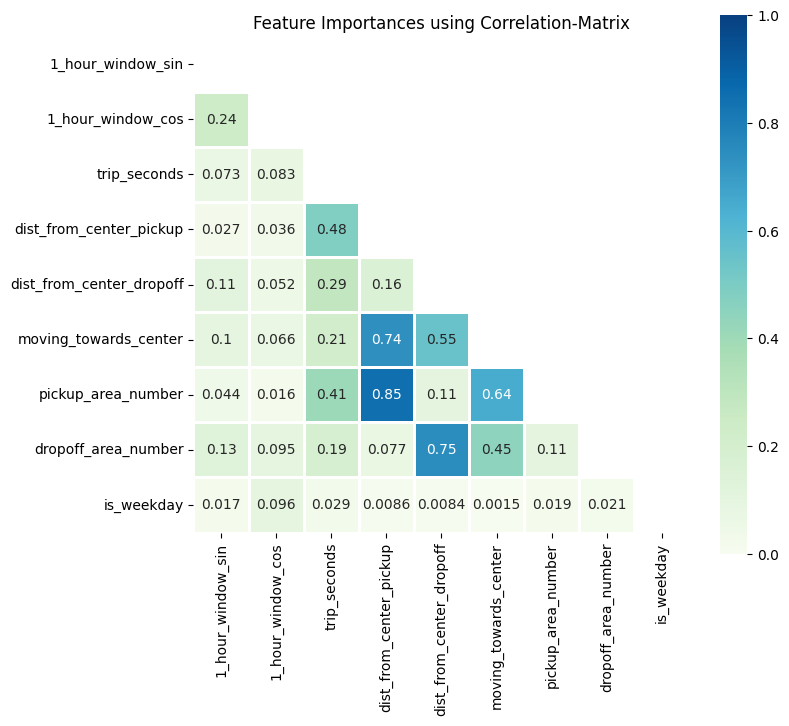

In [82]:
# Visualize features using heatmap
heatmap(df_scaled)

##### **5.1.2 Estimating cluster number**

SHOULD WE?? --- ((We use Mini-Batch KMeans for faster and more efficient calculations, since our dataset is quite big (https://medium.com/@tanvirhossen_29772/mini-batch-k-means-e3083cc765f5).)))

100%|██████████████████████████████████████| 10/10 [00:51<00:00,  5.18s/it]


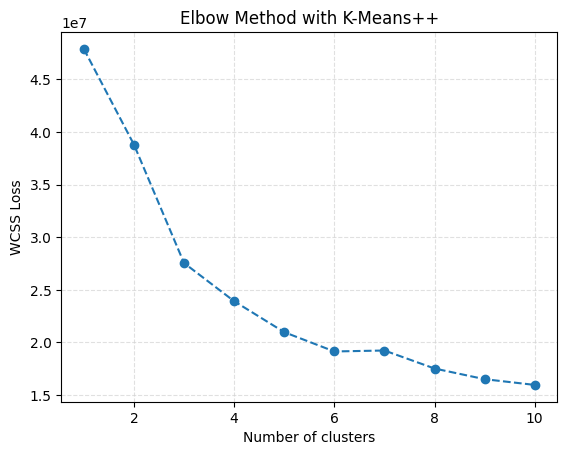

In [146]:
elbow_method(df_scaled, max_clusters=10)

Based on the elbow method, we can determine that a number of 4 clusters seems most optimal for our clustering task. 

In [134]:
# Max cluster number for rest of notebook
CLUSTER_NUMBER = 4

##### **5.1.3 K-means++ (Sampled with Silhouette plots)**

We first run k-means on a sampled dataframe (max. 10000 entries) to see whether or not the cluster number was picked appropriately. This may seem like a small dataframe in comparison to our original frame, however, for the purpose of determining the best cluster number, this gives a good first intuition. 

In [129]:
df_sampled = df_scaled.sample(n=10000, random_state=42)

100%|████████████████████████████████████████| 5/5 [00:19<00:00,  3.93s/it]


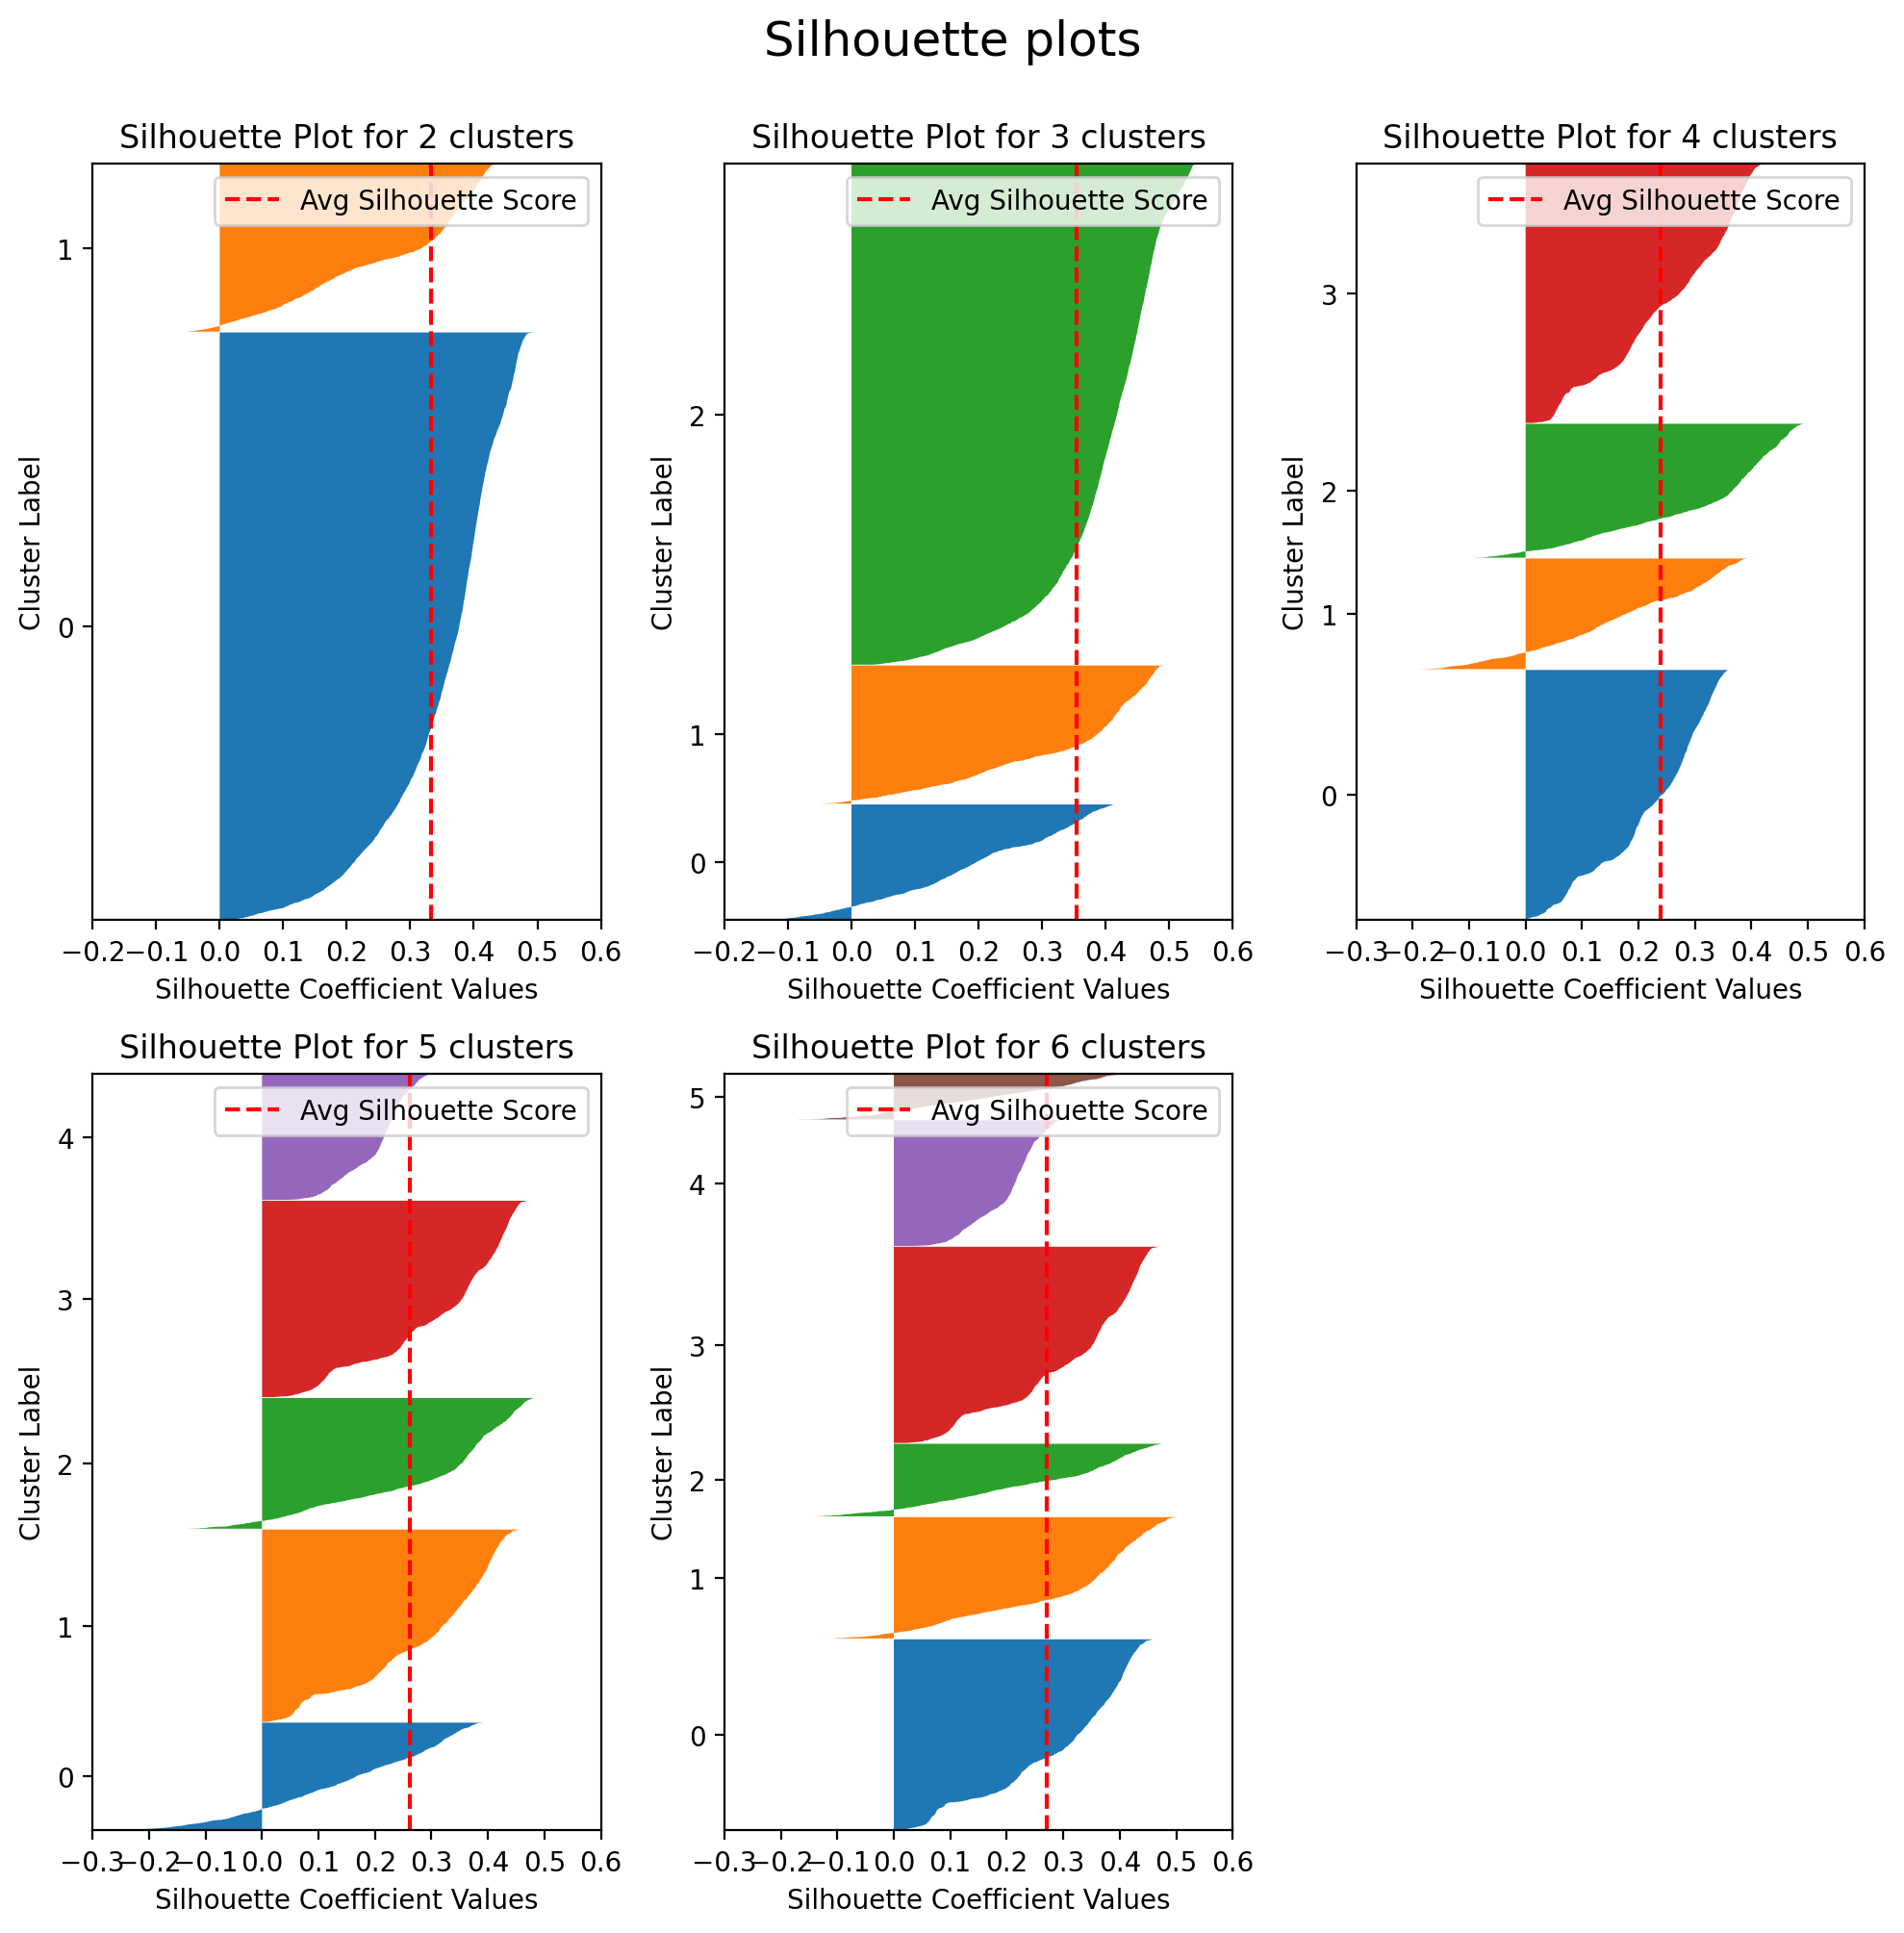

In [131]:
# Calculate number of rows needed for plot space
ncols = 3
nrows = CLUSTER_NUMBER // ncols + (CLUSTER_NUMBER % ncols > 0)
fig = plt.figure(figsize=(10,10), dpi=200)

# Add two more clusters to see if better results
for k in tqdm(range(2, CLUSTER_NUMBER+3)):
    km = KMeans(n_clusters = k, n_init= 10, random_state=42)
    km_fit = km.fit(df_sampled)
    
    # Visualize
    ax = plt.subplot(nrows, ncols, k-1)
    silhouette_plot(df_sampled, km_fit, ax)

fig.suptitle("Silhouette plots", fontsize=18, y=1)
plt.tight_layout()
plt.show()

It becomes evident that a cluster number of 4 seems to be the sweet spot. 

Silhouette Score measures goodness of fit for different cluster numbers by (b-a)/max(a,b) where:
- b: average distance between all clusters
- a: average distance between each point within a cluster

The score is between [-1, 1], where
- -1 means clusters are assigned wrong
- 1 means clusters are well apart 
- 0 means cluster distance is not significant

(https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

##### **5.1.4 K-means++ (Full df & visualizations)**

In [135]:
# Run kmeans++ (5 iterations)
kmeans = KMeans(n_clusters = 4, n_init= 5, random_state=42) 
prep_df['kmeans_cluster'] = kmeans.fit_predict(df_scaled)

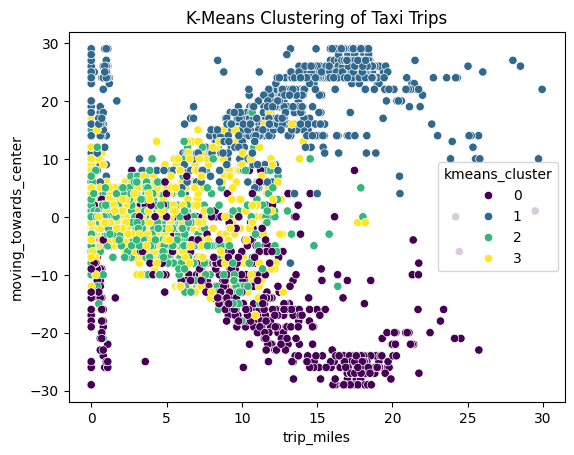

In [136]:
sns.scatterplot(x='trip_miles', y='moving_towards_center', hue='kmeans_cluster', data=fac, palette='viridis')
plt.title('K-Means Clustering of Taxi Trips')
plt.show()